**ARIMA**: AutoRegressive Integrated Moving Average model is characterized by 3 terms: p, q, d.

- **p:** is the order of the AR term
- **q:** is the order of the MA term
- **d:** is the number of differencing required to make the time series stationary

The first step to build an ARIMA model is to make the time series stationary. Because, term **Auto Regressive (AR)** in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as we know, work best when the predictors are not correlated and are independent from each other.

### AR and MA models

* AR models suppose that $Y_t$ is a linear function of previous values.

$Y_t = \alpha + \beta_1Y_{t-1} + \beta_2Y_{t-2} + \ldots + \beta_pY_{t-p} + \epsilon_1$

* MA models suggest that the series presents fluctuations around an average value. We consider that the best estimation is the weighted mean of some previous values. In other words, it's the true mean plus a weighted sum of previous errors.

$Y_t = \mu - (\phi_1\epsilon_{t-1} + \phi_2\epsilon_{t-2} + \ldots + \phi_q\epsilon_{t-q})$

where the error terms are the errors of the autoregressive models of the respective lags.

An ARIMA model is one where the time series was differenced at least once to make it stationary and which combine the AR and the MA terms.

### Find the order of differencing (d) in ARIMA model

The purpose of differencing it to make the time series stationary. But we need to be careful to not over-difference the series. Because, an over differenced series may still be stationary, which in turn will affect the model parameters.

*The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.*

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

In the event, we can't really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

Let's see how to do it with an example.

First, we're going to check if the series is stationary using the Augmented Dickey Fuller test (`adfuller()`), from the `statsmodels` package. Because, you need differencing only if the series is non-stationary. Else, no differencing is needed, that is, $d = 0$.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
df.head()

,value
0,88
1,84
2,85
3,85
4,84


In [34]:
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.464240
p-value: 0.124419


Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

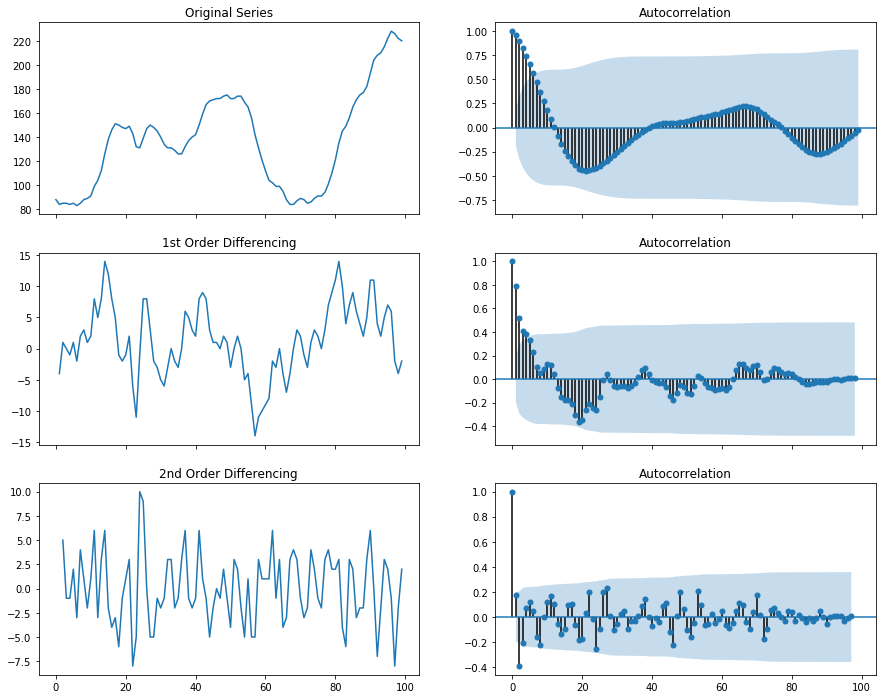

In [35]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(15, 12))
axes[0, 0].plot(df.value.values)
axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff().values)
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff().values)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But when looking at the autocorrelation plot for the 2nd differencing, the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

So, we're going to tentatively set the order of differencing at 1 even though the series is not perfectly stationary (weak stationarity).

### Find the order of the AR term (p)

The next step is to identify if the model needs any AR terms. We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions of the intermediate lags.

Partial autocorrelation of lag ($k$) of a series is the coefficient of that lag in the autoregression equation of Y.

$$Yt = \alpha_0 + \alpha_1 Y_{t-1} + \alpha_2 Y_{t-2} + \alpha_3 Y{t-3}$$

That is, suppose, if $Y_t$ is the current series and $Y_{t-1}$ is the lag 1 of Y, then the partial autocorrelation of lag 3 ($Y_{t-3}$) is the coefficient $\alpha_3$ of Y_t-3 in the above equation.

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

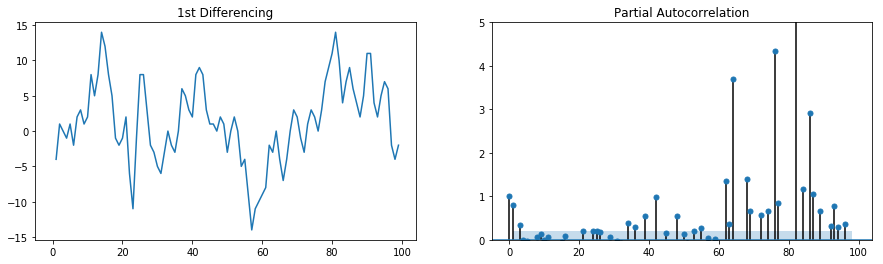

In [38]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 4))
axes[0].plot(df.value.diff().values)
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

We can observe that the PACF lag 1 is quite significant since it's well above the significance line. Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region). But we're going to be conservative and tentatively set the p at 1.

### Find the order of the MA term (q)

Just like how we looked at the PACF plot for the number of AR terms, we can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

Let’s see the autocorrelation plot of the differenced series.

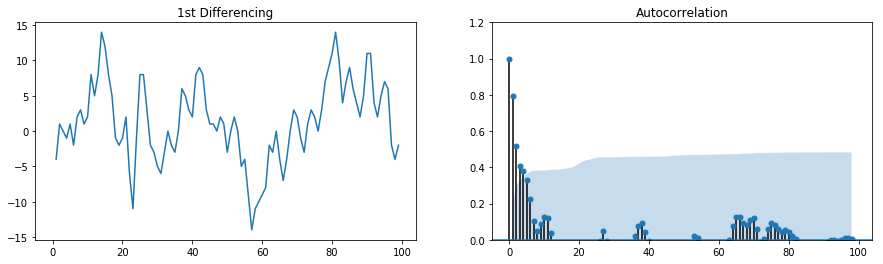

In [39]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 4))
axes[0].plot(df.value.diff().values)
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

Couple of lags are well above the significance line. So, let’s tentatively set q at 2.

**If the series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, we can try adding an additional MA term.**

### Build the ARIMA Model

In [44]:
# p=1, d=1, q=2 ARIMA Model
model = ARIMA(df.value, order=(1, 1, 2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Fri, 18 Oct 2019   AIC                            517.579
Time:                        14:08:30   BIC                            530.555
Sample:                             1   HQIC                           522.829
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1202      1.290      0.868      0.387      -1.409       3.649
ar.L1.D.value     0.6351      0.257      2.469      0.015       0.131       1.139
ma.L1.D.value     0.5287      0.355     

The model summary reveals a lot of information. The table in the middle is the coefficients table where the coef values are the weights of the respective terms.

Notice here the coefficient of the MA2 term is close to zero and the P-Value in P>|z| column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.

So, let's rebuild the model without the MA2 term.

In [46]:
# p=1, d=1, q=1 ARIMA Model
model = ARIMA(df.value, order=(1, 1, 1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Fri, 18 Oct 2019   AIC                            515.579
Time:                        14:11:50   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1205      1.286      0.871      0.386      -1.400       3.641
ar.L1.D.value     0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.value     0.5297      0.089     

The model AIC has reduced, which is good. The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

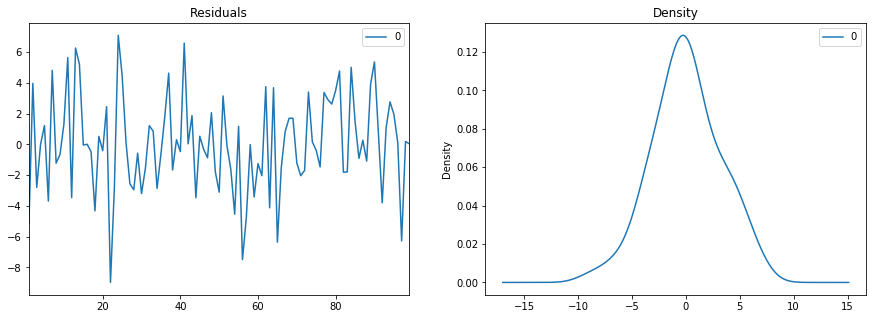

In [47]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using `plot_predict()`.

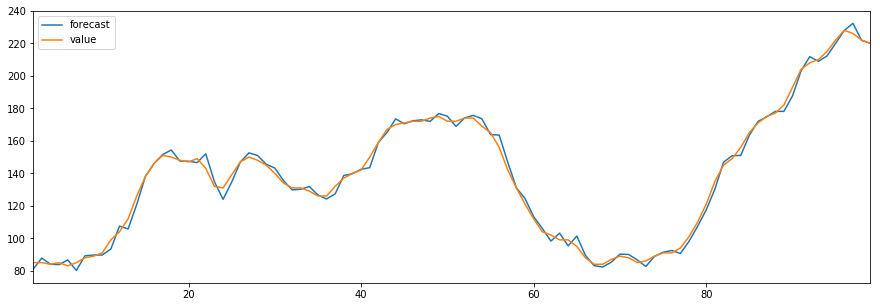

In [57]:
# Actual vs Fitted
fig, ax = plt.subplots(1, 1,figsize=(15, 5))
model_fit.plot_predict(dynamic=False, ax=ax)
plt.show()

When we set `dynamic=False` the in-sample lagged values are used for prediction.

That is, the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.

So, we seem to have a decent ARIMA model. But is that the best?

Can't say that at this point because we haven't actually forecasted into the future and compared the forecast with the actual performance.

So, the real validation we need now is the Out-of-Time cross-validation.

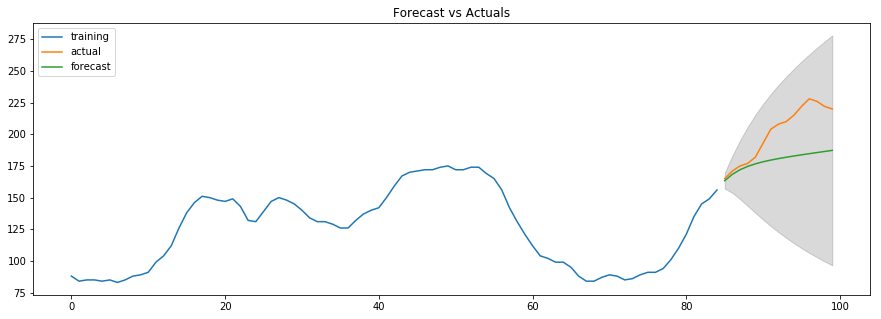

In [68]:
LIMIT = 85
REMAIN = df.shape[0] - LIMIT

train = df.value[:LIMIT]
test = df.value[LIMIT:]

model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)

# Forecast
forecast, stderr, conf_int = fitted.forecast(REMAIN, alpha=0.05)  # 95% conf

# Make as pandas series
forecast_series = pd.Series(forecast, index=test.index)
lower_series = pd.Series(conf_int[:, 0], index=test.index)
upper_series = pd.Series(conf_int[:, 1], index=test.index)

# Plot
plt.figure(figsize=(15, 5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(forecast_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left')
plt.show()

From the chart, the ARIMA(1,1,1) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.

But each of the predicted forecasts is consistently below the actuals. That means, by adding a small constant to our forecast, the accuracy will certainly improve. So, there is definitely scope for improvement.

So, what we're going to do is to increase the order of differencing to two, that is set d=2 and p=3

While doing this, we keep an eye on the P values of the AR and MA terms in the model summary. They should be as close to zero, ideally, less than 0.05.

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   83
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -214.248
Method:                       css-mle   S.D. of innovations              3.153
Date:                Fri, 18 Oct 2019   AIC                            440.497
Time:                        14:34:51   BIC                            455.010
Sample:                             2   HQIC                           446.327
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0483      0.084      0.577      0.565      -0.116       0.212
ar.L1.D2.value     1.1386      0.109     10.399      0.000       0.924       1.353
ar.L2.D2.value    -0.5923      0.155

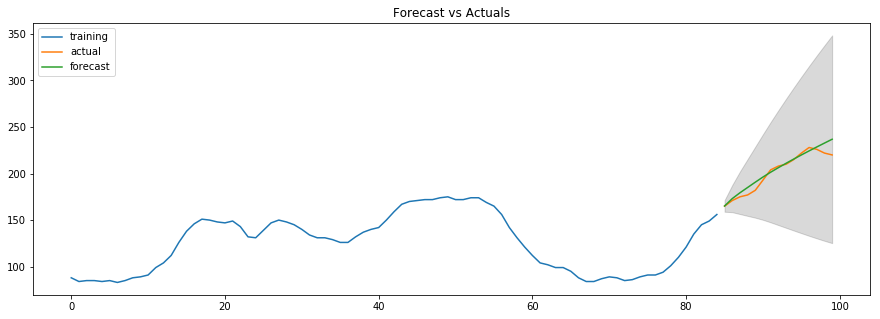

In [76]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(REMAIN, alpha=0.05)  # 95% conf

# Forecast
forecast, stderr, conf_int = fitted.forecast(REMAIN, alpha=0.05)  # 95% conf

# Make as pandas series
forecast_series = pd.Series(forecast, index=test.index)
lower_series = pd.Series(conf_int[:, 0], index=test.index)
upper_series = pd.Series(conf_int[:, 1], index=test.index)

# Plot
plt.figure(figsize=(15, 5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(forecast_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left')
plt.show()

The AIC has reduced to 440 from 515. Good. The P-values of the X terms are less the < 0.05, which is great.

So overall it’s much better.

Ideally, we should go back multiple points in time, like, go back 1, 2, 3 and 4 quarters and see how our forecasts are performing at various points in the year.

The forecast performance can be judged using various accuracy metrics.

The commonly used accuracy metrics to judge forecasts are:

- Mean Absolute Percentage Error (MAPE)
- Mean Error (ME)
- Mean Absolute Error (MAE)
- Mean Percentage Error (MPE)
- Root Mean Squared Error (RMSE)
- Lag 1 Autocorrelation of Error (ACF1)
- Correlation between the Actual and the Forecast (corr)
- Min-Max Error (minmax)

Typically, if we are comparing forecasts of two different series, the MAPE, Correlation and Min-Max Error can be used.

Why not use the other metrics?

Because only the above three are percentage errors that vary between 0 and 1. That way, we can judge how good is the forecast irrespective of the scale of the series.

In [79]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.022501367071734727,
 'me': 3.230813920923286,
 'mae': 4.548333218800461,
 'mpe': 0.016421146251518963,
 'rmse': 6.373258382464823,
 'acf1': 0.5105500852096979,
 'corr': 0.9674576396976206,
 'minmax': 0.021631595134893766}

###  How to do Auto Arima Forecast in Python?